Predicting TOALW, large errors from rough calculation

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [5]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [6]:
d_c2 = DS_w.TAU_OD2D.values
d_c2.shape

(71, 36, 72)

In [7]:
em = DS_w.EMISS.values #emissivity
em.shape 

(71, 36, 72)

In [8]:
lwr = DS_a.TOALW.values[1:,:,:] #top outer long wave radiation, remove first day of data
lwr.reshape(-1).shape

(181440,)

In [9]:
sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(52):
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


# Trying linear regression first

In [10]:
from sklearn.linear_model import LinearRegression
lwr_out = lwr.reshape(-1)
lr1 = LinearRegression()
lr1.fit(sla,lwr_out)
lwr_lin = lr1.predict(sla) #predicted

In [11]:
lr1.coef_

array([ 3.26196883e-08,  3.95612894e-08, -2.11527436e-08,  2.33517472e-09,
       -1.27663302e-09,  4.31792024e-09, -7.90926435e-10, -1.37536205e-09,
       -1.04148992e-08,  1.59502154e-08, -5.72266501e-09,  2.36065230e-08,
       -9.80825519e-08,  2.19491980e-07, -1.77278707e-07, -2.10077857e-08,
        1.42678772e-07, -9.69854383e-08,  1.65694942e-08, -2.45340637e-09,
       -3.23337446e-09, -2.16578862e-08,  2.11673239e-08, -1.56468225e-08,
        3.00809191e-08, -7.01673812e-08,  1.14912275e-07, -1.19545732e-07,
        1.34024333e-07, -1.51980657e-07,  1.64214427e-07, -1.35781917e-07,
        8.19385875e-08, -4.86462994e-08,  4.27721289e-08, -2.61905271e-08,
        1.68385483e-08, -6.28442720e-09, -6.65781386e-09,  3.92455490e-09,
        9.63776969e-09, -8.29256308e-09,  3.56119401e-09, -2.39701592e-10,
       -3.71813869e-09, -1.70551573e-09,  2.95842995e-09, -2.76038925e-09,
        1.52676272e-09, -1.08141407e-09,  5.81385251e-09, -5.09539611e-09,
        3.20387983e-09], 

In [12]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(lwr_out, lwr_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #smaller

7.1624217

In [13]:
lin_diff = lwr_out - lwr_lin

In [14]:
np.where(lin_diff == np.min(lin_diff))

(array([122045], dtype=int64),)

In [15]:
lwr_out[122045]

56.940372

In [16]:
np.min(lwr_out)

15.639853

In [17]:
lwr_lin[122045] #some pretty big differences...

94.986084

In [18]:
np.where(lin_diff > 50)

(array([  4113,   9297,  14481,  17073,  19665,  22257,  24849,  27441,
         30033,  32625,  35217,  37809,  40401,  42993,  45585,  48177,
         50769,  53361,  55953,  58545,  61137,  63729,  66321,  68913,
         71505,  74097,  76689,  79281,  81873,  87057,  92241,  94833,
         97425, 100017, 102609, 105201, 107793, 112977, 144081, 146673,
        151857, 162225, 175185, 180369], dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

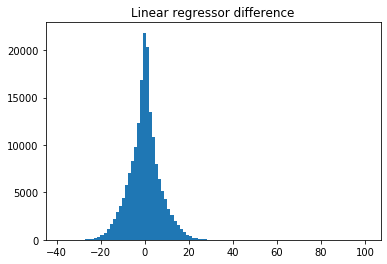

In [19]:
plt.hist(lin_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show

In [20]:
lwr_out.reshape(-1,1).shape

(181440, 1)

In [21]:
td = np.concatenate((sla, lwr_out.reshape(-1,1)), axis = 1) #total data

In [22]:
sla[:10*36*72,:].shape

(25920, 53)

In [23]:
sla[10*36*72:11*36*72,:]

array([[3.2982371e+08, 4.3012157e+08, 4.3130067e+08, ..., 2.3412691e+08,
        2.1674832e+08, 2.1496277e+08],
       [3.2989165e+08, 4.3018813e+08, 4.3141155e+08, ..., 2.3753515e+08,
        2.2025200e+08, 2.1499749e+08],
       [3.2991754e+08, 4.3020230e+08, 4.3146352e+08, ..., 2.4122179e+08,
        2.2397907e+08, 2.1495376e+08],
       ...,
       [1.7091520e+09, 1.5555758e+09, 1.5599835e+09, ..., 7.7389216e+08,
        8.3620032e+08, 6.6332077e+08],
       [1.7200332e+09, 1.5640590e+09, 1.5681286e+09, ..., 7.7153069e+08,
        8.3414899e+08, 6.6392493e+08],
       [1.7308575e+09, 1.5723578e+09, 1.5760733e+09, ..., 7.6968621e+08,
        8.3303002e+08, 6.6487891e+08]], dtype=float32)

# Let's try random forest regressor:

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rfr1 = RandomForestRegressor()
rfr1.fit(sla[:10*36*72,:],lwr_out[:10*36*72]) #training set
lwr_rfr = rfr1.predict(sla[10*36*72:11*36*72,:]) 

rfr_mse = mean_squared_error(lwr_out[10*36*72:11*36*72], lwr_rfr) #test the model on a single day
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2.309338448362865

In [25]:
rfr_diff = lwr_out[10*36*72:11*36*72] - lwr_rfr

<function matplotlib.pyplot.show(*args, **kw)>

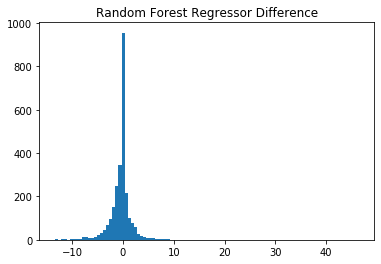

In [26]:
plt.hist(rfr_diff, bins = 100)
plt.title("Random Forest Regressor Difference")
plt.show #wow, much better!

In [27]:
real_out = lwr_out[10*36*72:11*36*72].reshape(36,72)
pred_out = lwr_rfr.reshape(36,72)

In [28]:
lwr_out[10*36*72:11*36*72]

array([18.744493, 18.748896, 18.750952, ..., 89.9946  , 90.497574,
       91.00019 ], dtype=float32)

In [29]:
np.array_equal(lwr_rfr,pred_out.reshape(-1))

True

In [30]:
real_out.shape

(36, 72)

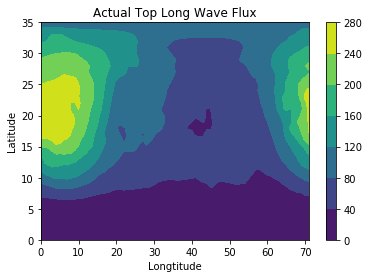

In [31]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual Top Long Wave Flux")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

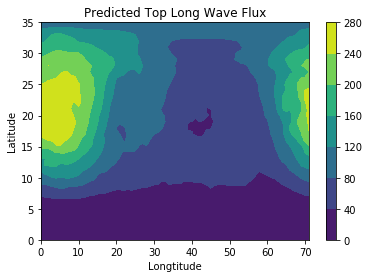

In [32]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted Top Long Wave Flux")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

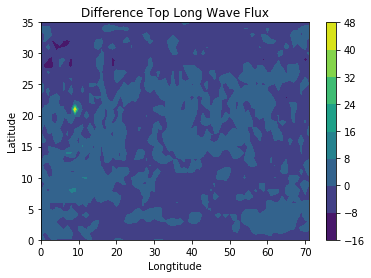

In [33]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference Top Long Wave Flux")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

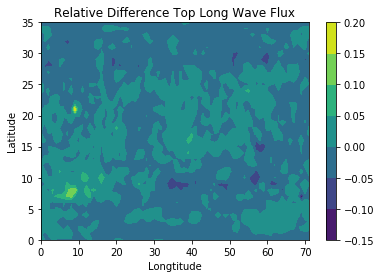

In [34]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference Top Long Wave Flux")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

Getting the integrals of flux error (and then getting average erroneusly added flux)

In [35]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [36]:
real_out.shape

(36, 72)

In [37]:
rfr_int_err = int_err(lwr_rfr, lwr_out[10*36*72:11*36*72], pd.DataFrame(lwr_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
np.array(rfr_int_err)/(1.44e14) #not bad

-0.31839302394771135